# Демо блокнот №2. Демонстрация работы алгоритмов кластеризации

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

## Генерация многомерных данных

In [66]:
SEED = 36
X, y_true = make_blobs(
    n_samples=2500,
    centers=7,
    n_features=10,
    cluster_std=[9.0, 4.0, 1.9, 9.5, 0.1, 1.2, 4.5],
    random_state=SEED
)
X = StandardScaler().fit_transform(X)
X.shape


(2500, 10)

In [67]:
X

array([[ 2.27351253,  1.54752305,  0.1032076 , ..., -0.98659148,
         0.36693967, -0.40760076],
       [-0.50907799, -0.18389493,  0.18289652, ...,  0.69752139,
        -0.14395758,  0.55753592],
       [-1.66776575,  1.35626988,  0.7292394 , ..., -1.13666367,
         0.70388081, -1.48485522],
       ...,
       [-1.43088804, -1.24972381, -0.75923577, ...,  1.55729175,
         0.06749971, -1.13876495],
       [ 0.66694469, -0.66724519,  0.43162994, ...,  0.87650639,
         0.70117931,  1.20553771],
       [ 0.84868395, -0.59136105,  0.34921995, ...,  0.83864328,
         0.87814072,  1.09227224]])

In [68]:
y_true

array([1, 4, 0, ..., 6, 5, 5])

## Сократим размерность для сгенерированных данных

In [69]:
dim_method = "pca" 

if dim_method.lower() == "pca":
    reducer = PCA(n_components=2, random_state=SEED)
elif dim_method.lower() == "tsne":
    reducer = TSNE(n_components=2, random_state=SEED, init="pca", learning_rate="auto", perplexity=40)
else:
    raise ValueError("dim_method ∈ {pca, tsne}")

Z = reducer.fit_transform(X)
Z.shape

(2500, 2)

## Как выглядят данные?

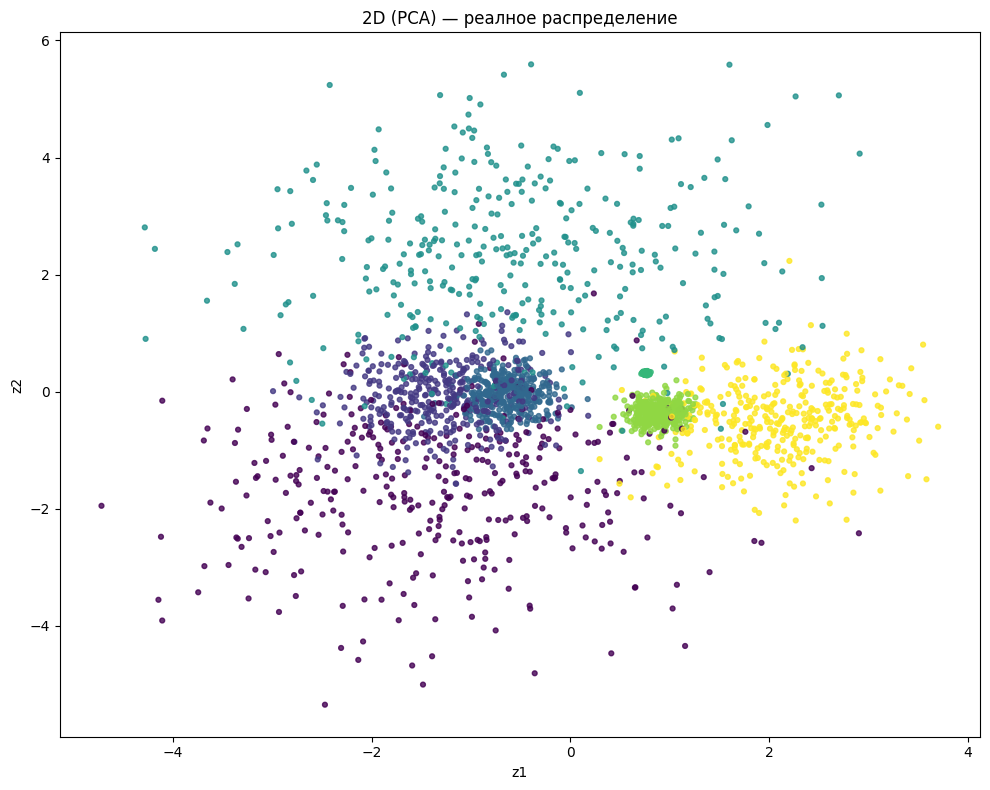

In [72]:
plt.figure(figsize=(10, 8))
plt.scatter(Z[:,0], Z[:,1], c=y_true, s=12, alpha=0.8)
plt.title(f"2D ({dim_method.upper()}) — реалное распределение")
plt.xlabel("z1"); plt.ylabel("z2")
plt.tight_layout(); plt.show()


In [74]:
def show_real_data():
    plt.figure(figsize=(10,8))
    plt.scatter(Z[:,0], Z[:,1], c=y_true, s=12, alpha=0.8)
    plt.title(f"2D ({dim_method.upper()}) — реалное распределение")
    plt.xlabel("z1"); 
    plt.ylabel("z2")
    plt.tight_layout(); plt.show()


## Применяем кластеризацию

In [78]:
def clustering_metrics(Z, labels):
    D = pairwise_distances(Z, Z)
    same = labels[:,None] == labels[None,:]
    np.fill_diagonal(same, False)

    # внутриклассовое среднее расстояние: среднее по всем внутриклассовым парам
    intra_mask = same
    intra_vals = D[intra_mask]
    intra_mean = intra_vals.mean() if intra_vals.size else np.nan

    # межкластерное среднее расстояние: среднее по всем парам из разных кластеров
    inter_mask = ~same
    np.fill_diagonal(inter_mask, False)
    inter_vals = D[inter_mask]
    inter_mean = inter_vals.mean() if inter_vals.size else np.nan

    # суммарная выборочная дисперсия в 2D (сумма дисперсий по осям)
    total_var = np.var(Z, axis=0, ddof=1).sum()
    return intra_mean, inter_mean, total_var

def run_and_plot(name, labels):
    intra, inter, tvar = clustering_metrics(Z, labels)
    print(f"{name}: intra={intra:.3f}, inter={inter:.3f}, total_var={tvar:.3f}")
    plt.figure(figsize=(10,8))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=12, alpha=0.85)
    plt.title(f"{name} на 2D ({dim_method.upper()})")
    plt.xlabel("z1"); plt.ylabel("z2")
    plt.tight_layout(); plt.show()


### k-Means

In [79]:
k = 10

KMeans: intra=0.597, inter=2.605, total_var=3.707


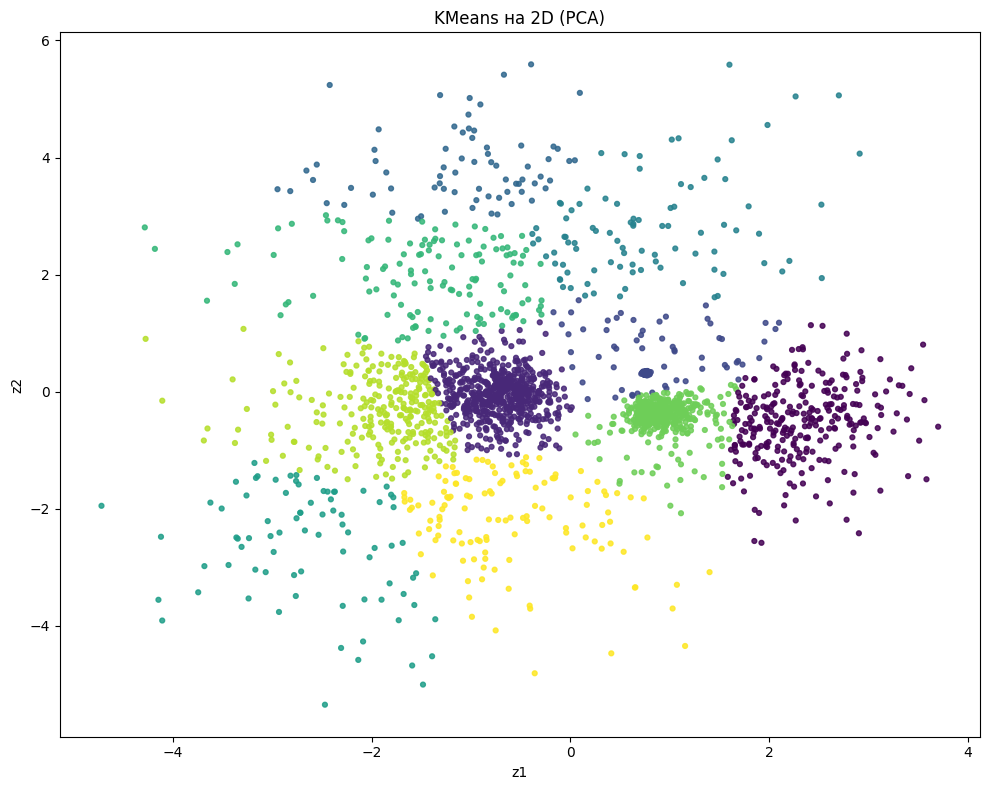

In [80]:
km = KMeans(n_clusters=k, n_init="auto", random_state=SEED)
labels_km = km.fit_predict(Z)
run_and_plot("KMeans", labels_km)


KMeans: intra=0.334, inter=2.483, total_var=3.707


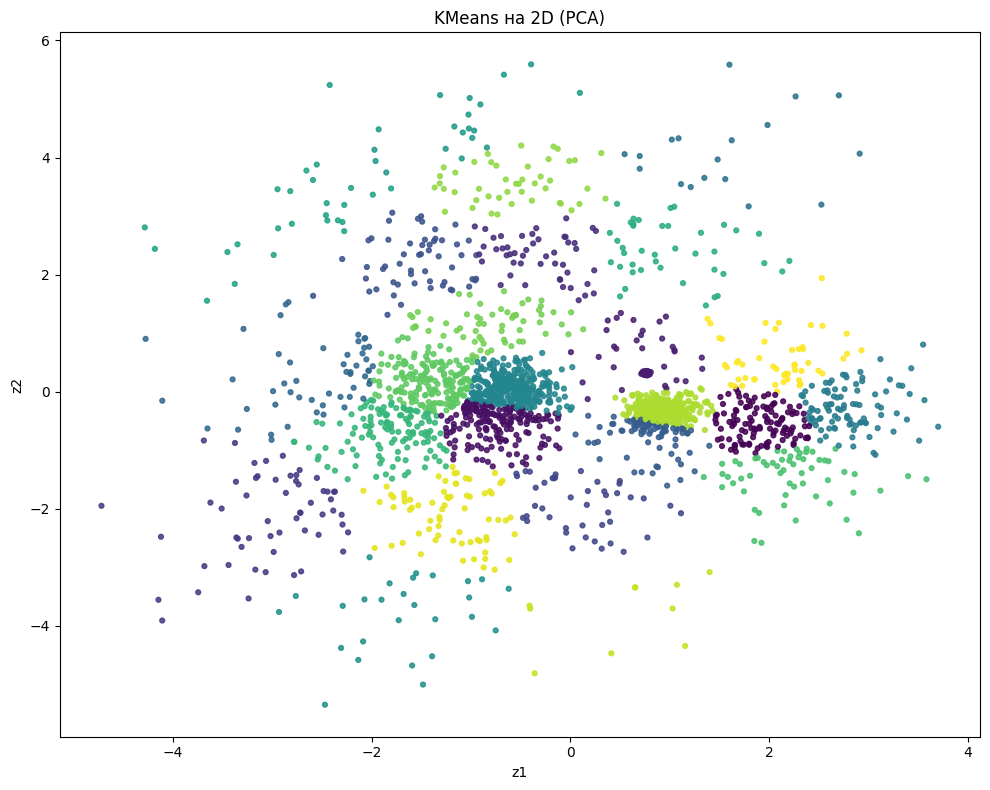

In [82]:
km = KMeans(n_clusters=25, n_init="auto", random_state=SEED)
labels_km = km.fit_predict(Z)
run_and_plot("KMeans", labels_km)


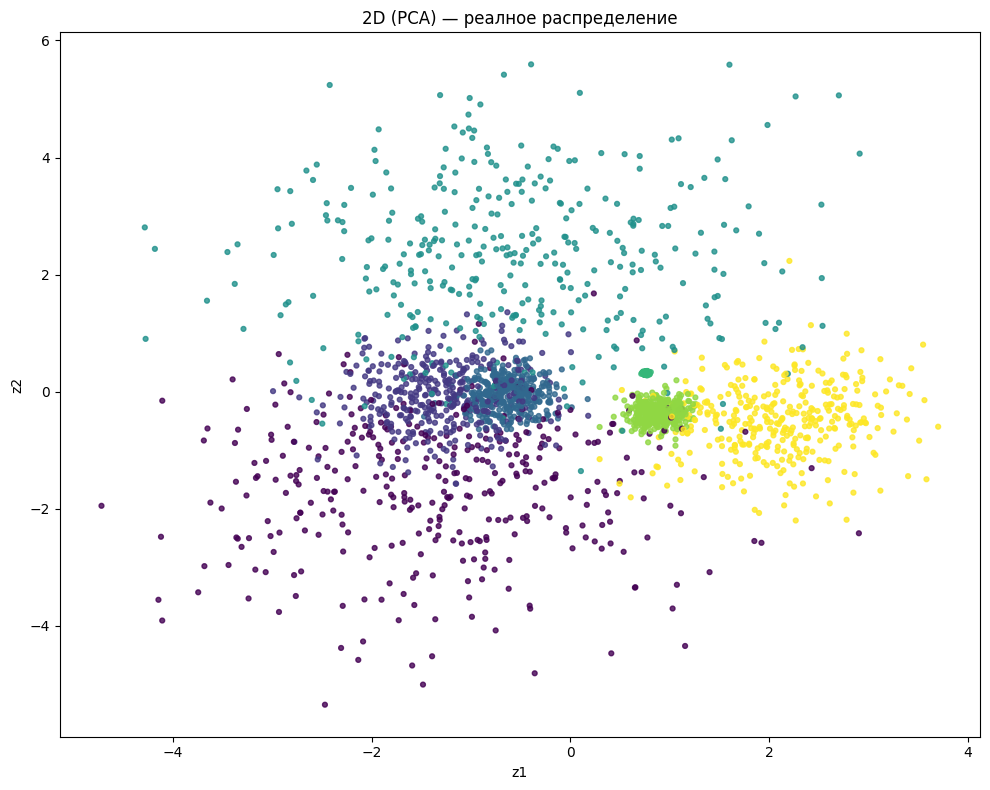

In [83]:
show_real_data()

### Алгомеративная кластеризация

In [84]:
from sklearn.cluster import AgglomerativeClustering

linkage_method = "average"   # "single", "complete", "average"
metric = "euclidean"

agg = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.0,
    linkage=linkage_method,
    metric=metric,
    compute_distances=True
)
agg.fit(X)


,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'average'
,distance_threshold,0.0
,compute_distances,True


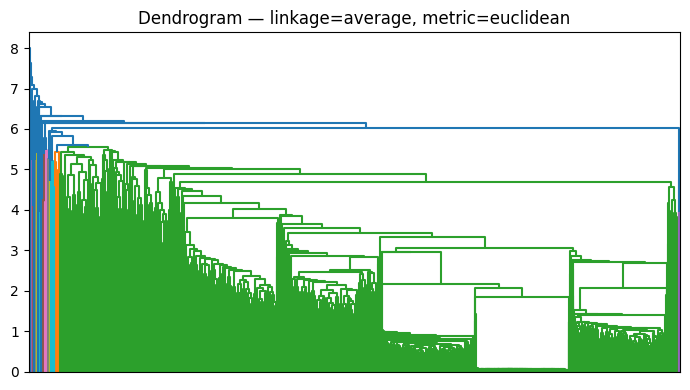

In [85]:
import numpy as np
from matplotlib import pyplot as plt

def plot_sklearn_dendrogram(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        c1 = 1 if merge[0] < n_samples else counts[merge[0] - n_samples]
        c2 = 1 if merge[1] < n_samples else counts[merge[1] - n_samples]
        counts[i] = c1 + c2
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    from scipy.cluster.hierarchy import dendrogram
    dendrogram(linkage_matrix, no_labels=True)
    return linkage_matrix  # вернём, чтобы не считать дважды

plt.figure(figsize=(7,4))
L = plot_sklearn_dendrogram(agg)
plt.title(f"Dendrogram — linkage={linkage_method}, metric={metric}")
plt.tight_layout(); plt.show()


In [86]:

from scipy.cluster.hierarchy import fcluster

def plot_hierarchy_level(model, Z, *, k=None, height=None):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        c1 = 1 if merge[0] < n_samples else counts[merge[0] - n_samples]
        c2 = 1 if merge[1] < n_samples else counts[merge[1] - n_samples]
        counts[i] = c1 + c2
    L = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    if (k is None) == (height is None):
        raise ValueError("Укажите ровно один параметр: k или height")

    if k is not None:
        labels = fcluster(L, t=k, criterion="maxclust")
        title = f"k={k}"
    else:
        labels = fcluster(L, t=height, criterion="distance")
        title = f"cut @ h={height:.3f}"

    plt.figure(figsize=(5,4))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=14)
    plt.title(f"Hierarchy level: {title}")
    plt.tight_layout(); plt.show()
    return labels


In [87]:

def plot_hierarchy_levels_grid(model, Z, *, heights=None, ks=None, ncols=3):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        c1 = 1 if merge[0] < n_samples else counts[merge[0] - n_samples]
        c2 = 1 if merge[1] < n_samples else counts[merge[1] - n_samples]
        counts[i] = c1 + c2
    L = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    panels = []
    if heights is not None:
        panels = [("h", h) for h in heights]
    elif ks is not None:
        panels = [("k", k) for k in ks]
    else:
        hs = np.quantile(L[:,2], [0.2, 0.4, 0.6, 0.8])
        panels = [("h", h) for h in hs]

    import math
    n = len(panels)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.6*nrows))
    axes = np.atleast_1d(axes).ravel()

    from scipy.cluster.hierarchy import fcluster

    for ax, (mode, val) in zip(axes, panels):
        if mode == "k":
            labels = fcluster(L, t=val, criterion="maxclust")
            ax.set_title(f"k={val}")
        else:
            labels = fcluster(L, t=val, criterion="distance")
            ax.set_title(f"h={val:.2f}")
        ax.scatter(Z[:,0], Z[:,1], c=labels, s=12)
        ax.set_xticks([]); ax.set_yticks([])

    for ax in axes[n:]:
        ax.axis("off")
    plt.tight_layout(); plt.show()

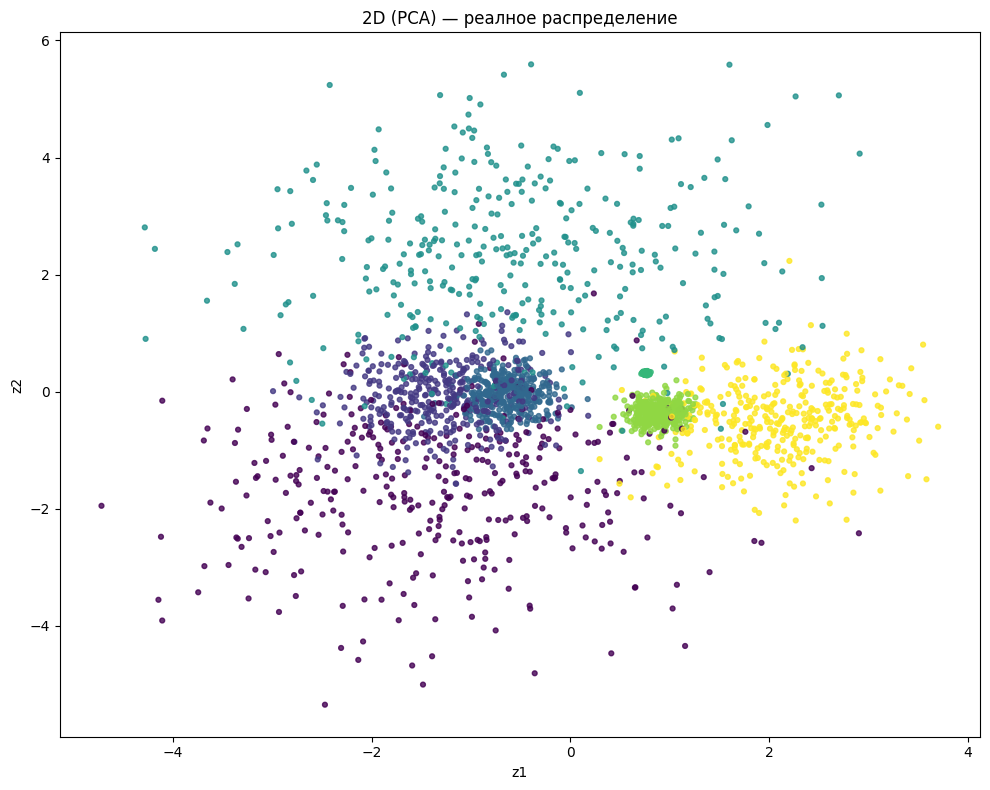

In [88]:
show_real_data()

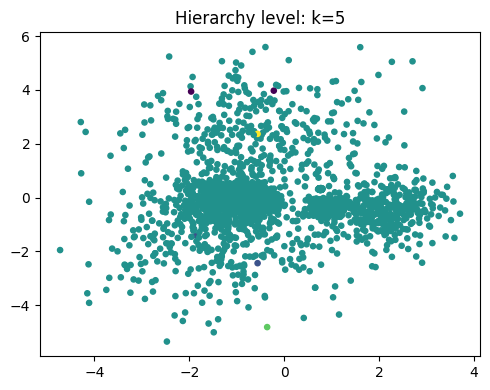

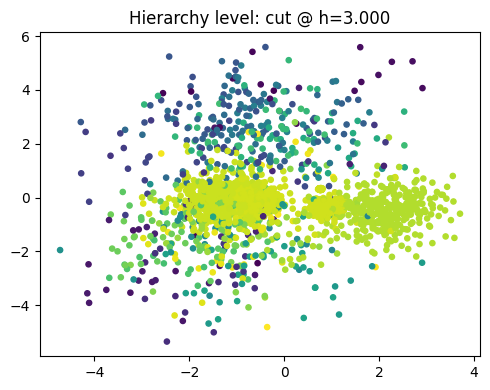

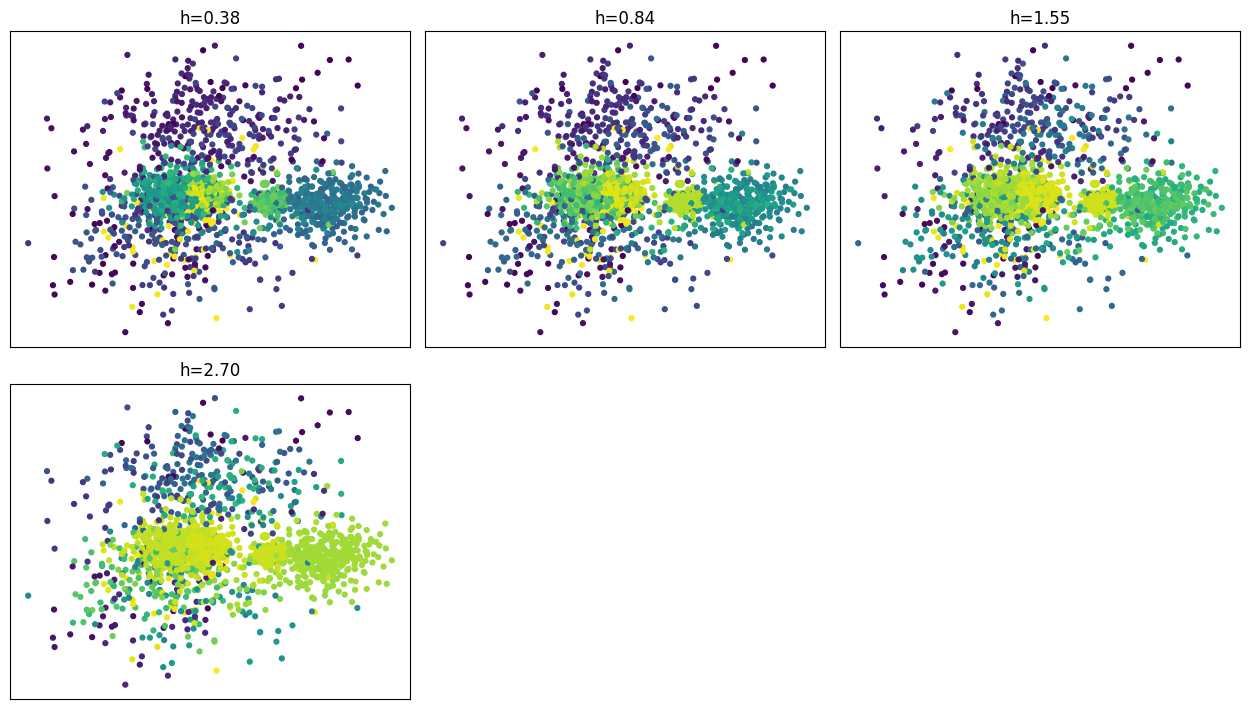

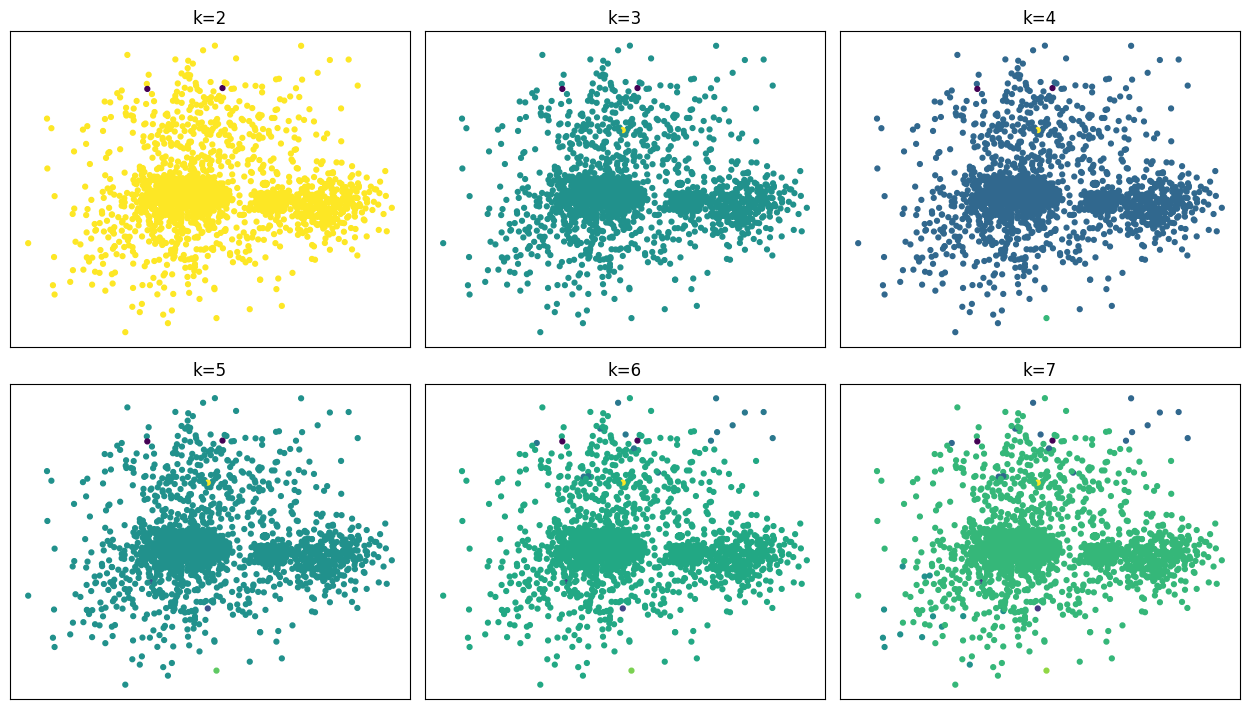

In [89]:
# один уровень по числу кластеров
plot_hierarchy_level(agg, Z, k=5)

# один уровень по высоте среза
plot_hierarchy_level(agg, Z, height=3.0)

# решётка из уровней (по квантилям высот)
plot_hierarchy_levels_grid(agg, Z)

# решётка по конкретным k
plot_hierarchy_levels_grid(agg, Z, ks=[2,3,4,5,6,7])


### DBSCAN

DBSCAN (eps≈0.31, min_samples=6): intra=2.007, inter=3.978, total_var=3.707


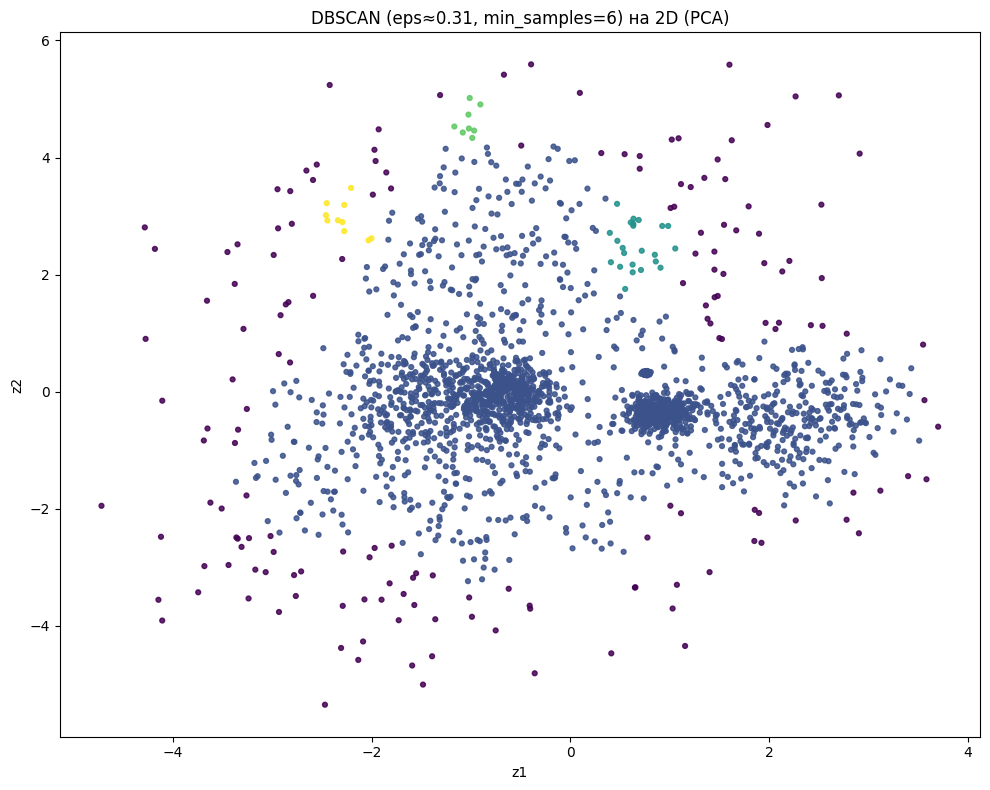

In [95]:
from sklearn.neighbors import NearestNeighbors

min_samples = 6

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(Z)
dists, _ = nbrs.kneighbors(Z)
eps = np.percentile(dists[:, -1], 90)  # простой эвристический выбор eps

db = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = db.fit_predict(Z)
run_and_plot(f"DBSCAN (eps≈{eps:.2f}, min_samples={min_samples})", labels_db)


In [91]:
labels_db

array([0, 0, 0, ..., 0, 0, 0])